# Project 5: Ballistic Vehicle Altimetry System Design
>**Date Created**: 8 April 2024<br>
>**Course**: AEM556 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [589]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from scipy.integrate import odeint
from scipy.linalg import cholesky
import os

plt.rcParams["text.usetex"] = False

plt.rcParams["legend.edgecolor"] = "black"

In [590]:
data = "altimeter_data.csv"
df = pd.read_csv(data, header=None, names=["t", "yk", "hk", "sk", "cbk"])

In [591]:
# Create symbolic representations of variables to compute jacobians using SymPy
h, s, d, delt, cb, rn, hr, hn, re, gn = sp.symbols(
    r"h s d \Delta{t} C_b \rho_0 h_\rho h_0 R_E g_0"
)

# A. Implement an extended Kalman filter (EKF) to estimate the vehicle states, $h$ and $s$, and the ballistic coefficient parameter, $C_b$.

### Dynamics Model

In [592]:
def propogate(x):
    """Function to propogate full nonlinear dynamics with euler (first order) integration"""
    dt = 0.5
    rho_0 = 0.0765
    g0 = 32.2
    h_rho = 30000
    Re = 20902260
    h = x[0]
    s = x[1]
    cb = x[2]

    hkp1 = h + dt * s
    skp1 = s + dt * (
        ((rho_0 * s**2) / (2 * cb) * np.exp(-h / h_rho))
        - (g0 * ((Re / (Re + h)) ** 2))
    )
    cbkp1 = cb
    return np.array([hkp1, skp1, cbkp1])

In [593]:
def jacobian_F(x):
    """Function that computes analytical jacobian of F at state x"""
    F_discrete_symbolic = sp.Matrix(
        [
            [h + delt * s],
            [
                s
                + (
                    delt
                    * (
                        ((rn * s**2) / (2 * cb) * sp.exp(-h / hr))
                        - (gn * ((re / (re + h)) ** 2))
                    )
                )
            ],
            [cb],
        ]
    )
    constants_mapper = dict(
        zip([delt, rn, gn, hr, re], [0.5, 0.0765, 32.2, 30000, 20902260])
    )  # Use given constant values to map to symbolic
    F_jacobian_symbolic = F_discrete_symbolic.jacobian([h, s, cb]).subs(
        constants_mapper
    )  # take jacobian and substitute in numerical values

    x = (np.array(x)).flatten()
    h_in = x[0]
    s_in = x[1]
    cb_in = x[2]
    F_jacobian = F_jacobian_symbolic.subs({h: h_in, s: s_in, cb: cb_in})
    return np.array(F_jacobian).astype(np.float64)

### Measurement Model

In [594]:
def get_measurement(x):
    """Computes predicted measurement using nonlinear measurement model"""
    h_in = x[0]
    d = 100000
    out = np.sqrt(d**2 + h_in**2)
    return out

In [595]:
def jacobian_H(x):
    h_in = x[0]
    s_in = x[1]
    cb_in = x[2]
    measurement_function = sp.Matrix([sp.sqrt(d**2 + h**2)])
    jacobian_H = measurement_function.jacobian([h, s, cb]).subs(
        {h: h_in, s: s_in, d: 100000}
    )
    return np.array(jacobian_H).astype(np.float64).flatten()

### Filter Equations

In [596]:
def predict(x_in, P_in, Q):
    F_jacobian = jacobian_F(x_in)
    x_k_km1 = propogate(x_in)
    P_k_km1 = F_jacobian @ P_in @ F_jacobian.T + Q
    return x_k_km1, P_k_km1


def update(x_k_km1, P_k_km1, range_meas):
    predicted_meausurement = get_measurement(
        x_k_km1
    )  # Use measurement model h(x) to get predicted meas. based on dynamics
    y_tilde = predicted_meausurement - range_meas
    Hk = jacobian_H(x_k_km1)
    Sk = (Hk @ P_k_km1 @ Hk.T) + R
    Kk = (P_k_km1 @ Hk.T) / Sk
    x_k_k = x_k_km1 - np.dot(Kk, y_tilde)
    Krk = Kk.reshape(3, 1) @ R.reshape(1, 1) @ Kk.reshape(1, 3)
    imkh = np.eye(3) - (Kk.reshape(3, 1) @ Hk.reshape(1, 3))
    P_k_k = imkh @ P_k_km1 @ imkh.T
    return x_k_k, P_k_k

### Run Filter on Measurements

In [597]:
P0 = np.diag([100**2, 10**2, 1])
Q = np.diag([10**2, 10**2, 0.05**2])
R = np.array([100**2])
x0 = np.array([400000, -2000, 20])

n = len(df["yk"])
res = np.zeros((n, 3))
Pks = np.zeros((n, 3, 3))
measurements_vector = df["yk"].to_numpy()
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        res[k] = x
        Pks[k] = P
        continue
    x_k_k1, P_k_k1 = predict(x, P, Q)
    x_k_k, P_k_k = update(x_k_k1, P_k_k1, measurements_vector[k])
    x = x_k_k
    P = P_k_k
    res[k] = x
    Pks[k] = P

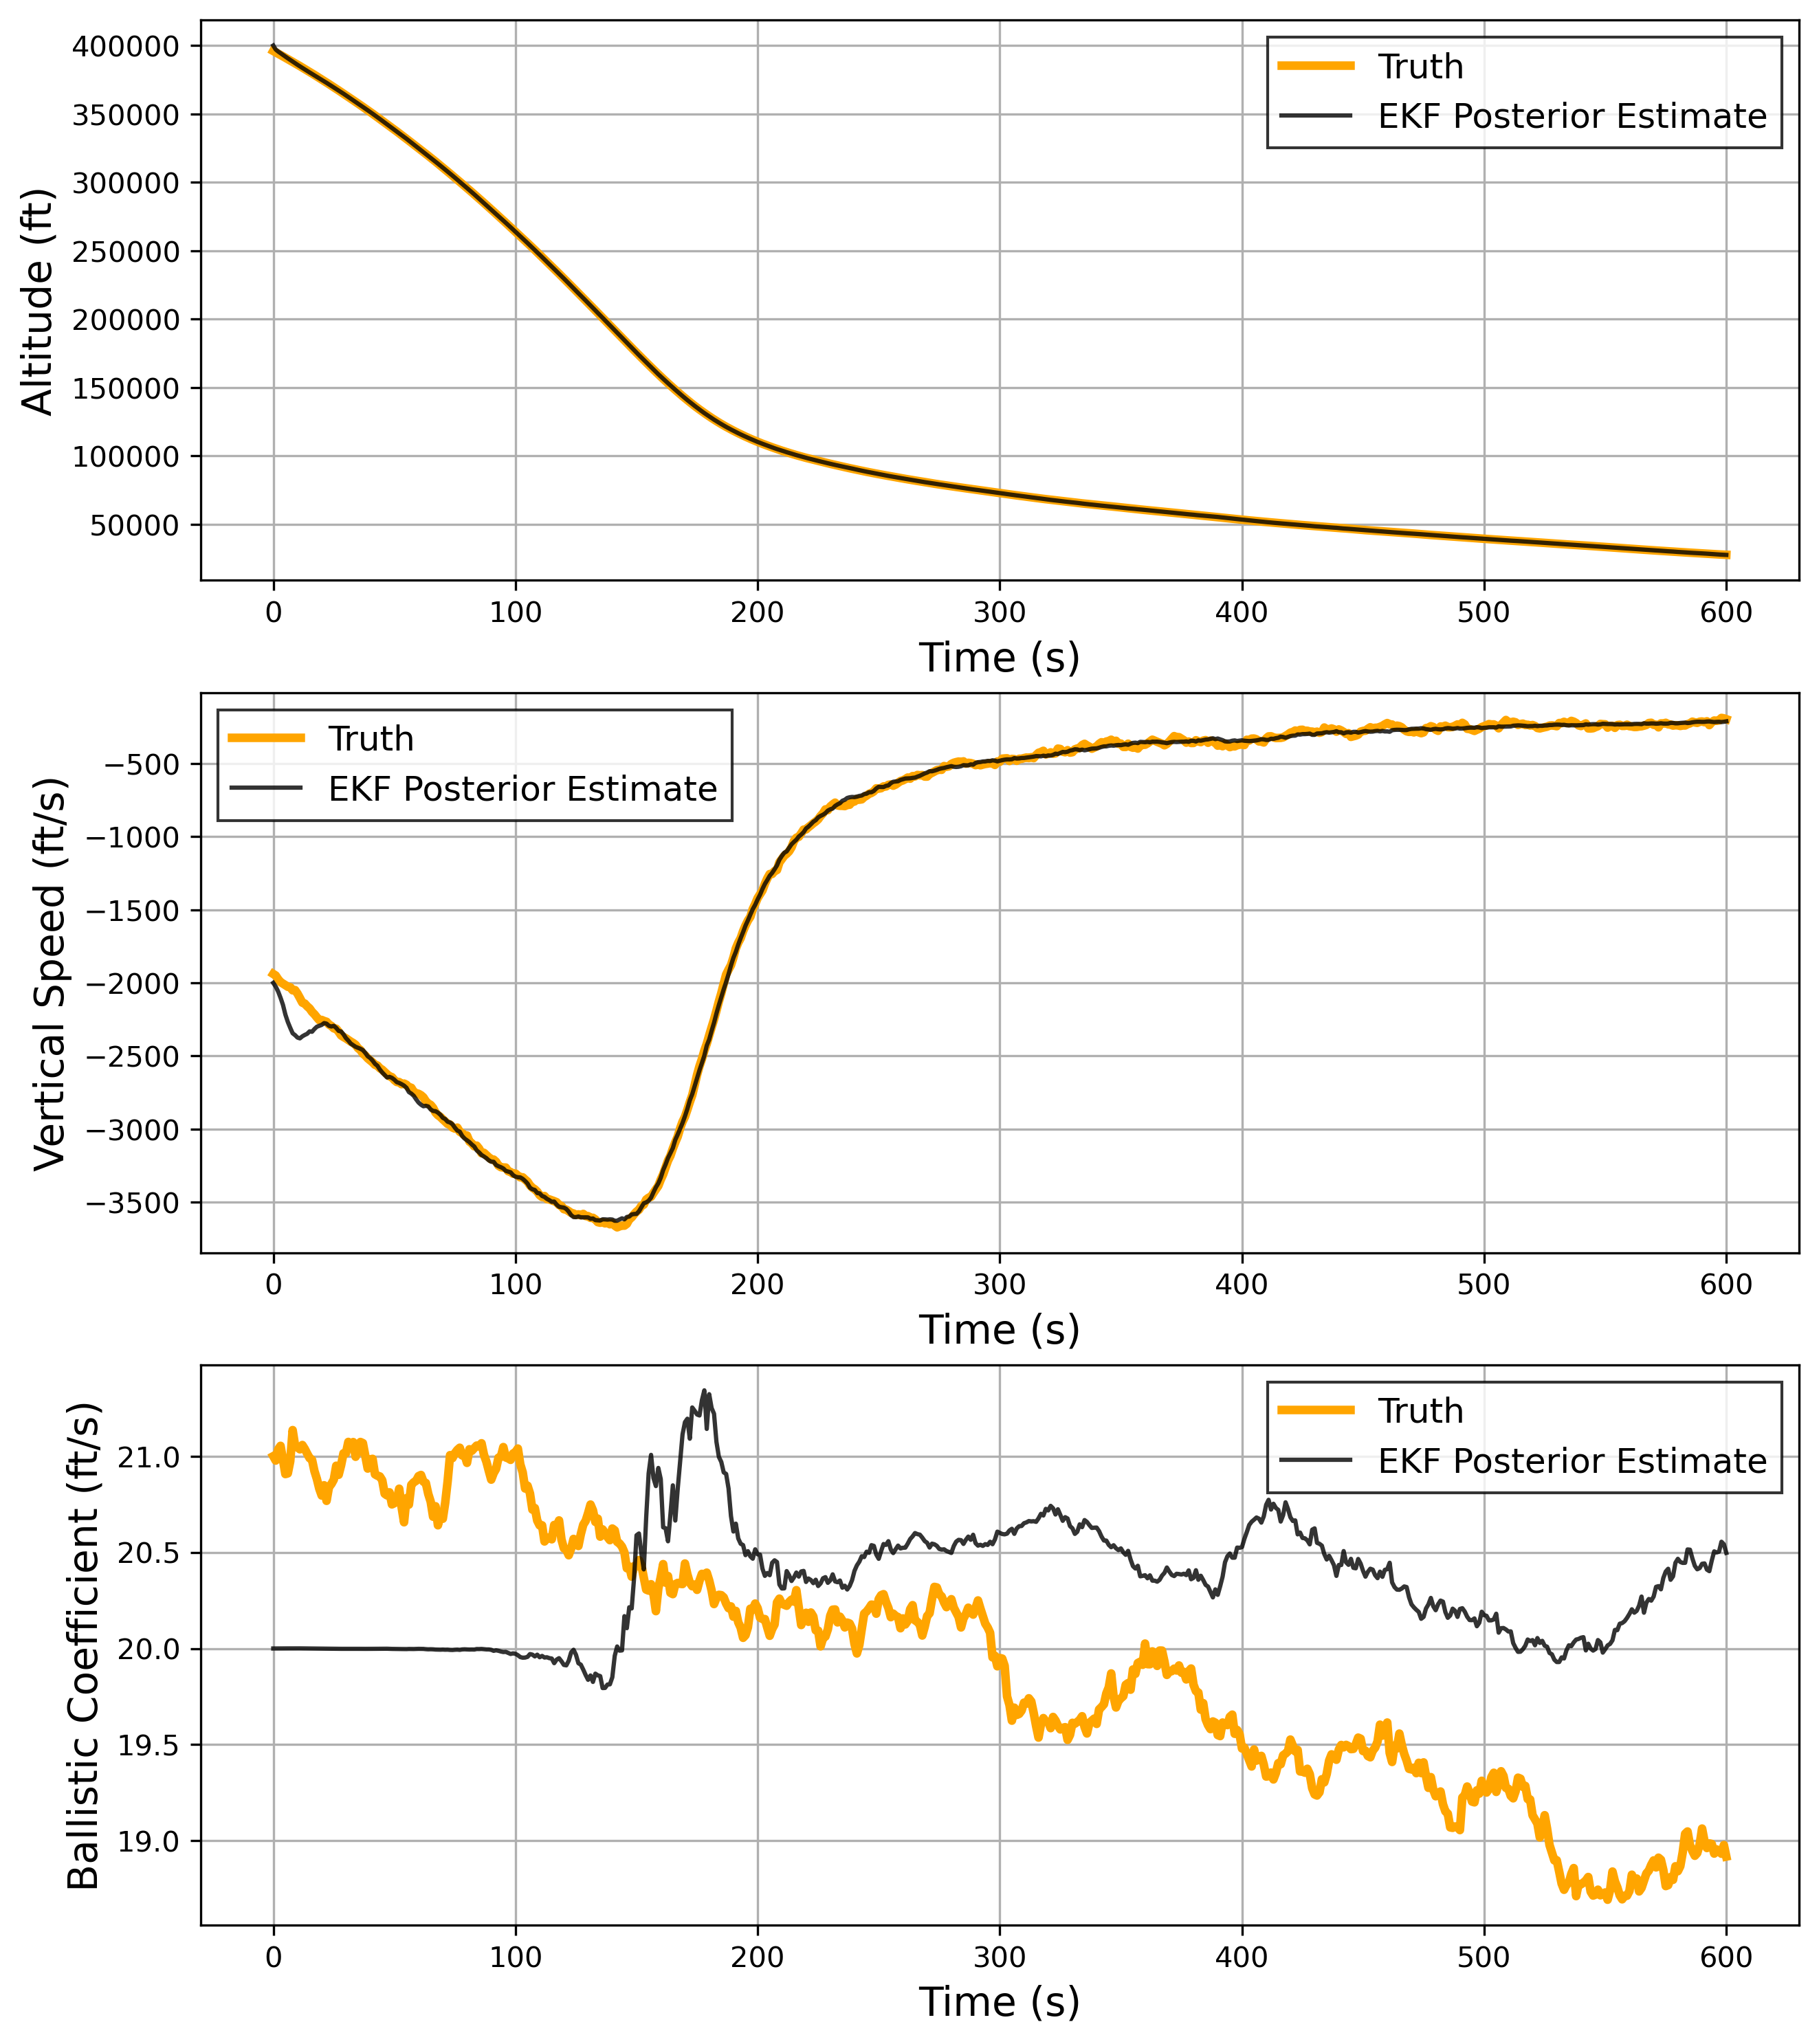

In [639]:
fig, (ax1, ax2, ax3) = plt.subplots(
    dpi=300, figsize=(10, 12), nrows=3, ncols=1, sharex=False
)
ax1.plot(df["hk"], c="orange", linestyle="-", lw=3, label="Truth")
ax1.plot(res[:, 0], c="black", linestyle="-", alpha=0.8, label="EKF Posterior Estimate")
ax1.grid()
leg = ax1.legend(fancybox=False, fontsize=12)
ax1.set_xlabel("Time (s)", fontsize=14)
ax1.set_ylabel("Altitude (ft)", fontsize=14)

ax2.plot(df["sk"], c="orange", linestyle="-", lw=3, label="Truth")
ax2.plot(res[:, 1], c="black", linestyle="-", alpha=0.8, label="EKF Posterior Estimate")
ax2.grid()
leg = ax2.legend(fancybox=False, fontsize=12)
ax2.set_xlabel("Time (s)", fontsize=14)
ax2.set_ylabel("Vertical Speed (ft/s)", fontsize=14)

ax3.plot(df["cbk"], c="orange", linestyle="-", lw=3, label="Truth")
ax3.plot(res[:, 2], c="black", linestyle="-", alpha=0.8, label="EKF Posterior Estimate")
ax3.grid()
leg = ax3.legend(fancybox=False, fontsize=12)
ax3.set_xlabel("Time (s)", fontsize=14)
ax3.set_ylabel("Ballistic Coefficient (ft/s)", fontsize=14)
plt.show()

# B. Implement a sigma-point Kalman filter (SPKF), e.g., an unscented Kalman filter (UKF), to estimate the vehicle states, $h$ and $s$, and the ballistic coefficient parameter, $C_b$.

### Functions for Unscented Transform

In [640]:
def get_sigmas_weights(X, P, alpha=1e-3, beta=2, k=0):
    L = len(X)
    lamda = alpha**2 + (L + k) - L

    # Define arrays to hold sigma points and weights
    sigs, wc, wm = np.zeros((2 * L + 1, L)), np.zeros(2 * L + 1), np.zeros(2 * L + 1)

    # Get sigma points
    U = cholesky((L + lamda) * P)  # L + lambda*P is a matrix, find its
    sigs[0] = X
    for k in range(L):
        sigs[k + 1] = (
            sigs[0] + U[k]
        )  # for points i = 1 ... L make on positive side of mean
        sigs[L + k + 1] = (
            sigs[0] - U[k]
        )  # for points i = (L+1) ... 2*L make on negative side of mean

    # Get weights
    wm[0] = lamda / (L + lamda)
    wc[0] = (lamda / (L + lamda)) + (1 - alpha**2 + beta)
    for k in range(2 * L):
        wm[k + 1] = 1 / (2 * (L + lamda))
        wc[k + 1] = 1 / (2 * (L + lamda))
    return sigs, wm, wc

In [641]:
def ukf_predict(Xin, Pin, Qin, alpha=1e-3, beta=2, k=0):
    L = len(Xin)
    P_out = np.zeros(Pin.shape)

    # Compute sigma points and pass them through nonlinear state transition function
    sigmas, weights_mean, weights_covariance = get_sigmas_weights(Xin, Pin)
    transformed_points = propogate(
        sigmas.T
    ).T

    # Compute weighted priori state mean with transformed sigma points
    x_k_km1 = np.dot(
        weights_mean, transformed_points
    )  

    # Compute weighted state covariance prior 
    for i, sigpt in enumerate(transformed_points):
        diff = (sigpt - x_k_km1).reshape(3, 1)
        P_out += weights_covariance[i] * np.dot(diff, diff.T)
    P_k_km1 = P_out + Q
    
    return x_k_km1, P_k_km1, weights_mean, weights_covariance, transformed_points

In [656]:
def ukf_update(Xin, Pin, Rin, measurement_in, sigmas_in, weights_mean, weights_cov):
    # Define constants and matrices to hold covariances
    L = len(Xin)
    Pz = np.zeros(Rin.shape)
    Pxz = np.zeros((1,3))

    # Pass sigma points through measurement function and compute weighted mean
    Z = get_measurement(sigmas_in.T)
    mu_z = np.dot(weights_mean, Z)

    # Compute measurement covariance, innovation, and state/meas cross covariance
    for k, predicted_meausurement in enumerate(Z):
        diff = predicted_meausurement - mu_z
        Pz+= weights_cov[k] * np.dot(diff,diff.T)
    Pz+= Rin
    y = measurement_in - mu_z

    for i, sig_point in enumerate(sigmas_in):
        d1 = (sig_point - Xin)
        d2 = (Z[i] - mu_z).T
        Pxz += weights_cov[i]*np.dot(d1,d2)

    # Compute kalman gain and form posterior state and covariance
    K = (Pxz/Pz).flatten()
    x_k_k = (Xin + np.dot(K, y)).flatten()
    P_k_k = Pin - np.outer(K*Pz, K.T)
    return x_k_k, P_k_k

### Run Filter on Measurements

In [657]:
n = len(df["yk"])-1
measurements_vector = df["yk"].to_numpy()
ukf_res = np.zeros((n, 3))
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        ukf_res[k] = x
        continue
    x_k_k1, P_k_k1, wm, wc, spts = ukf_predict(x, P, Q)
    x_k_k, P_k_k = ukf_update(x_k_k1, P_k_k1, R, measurements_vector[k], spts, wm, wc)
    x = x_k_k
    P = P_k_k
    ukf_res[k] = x

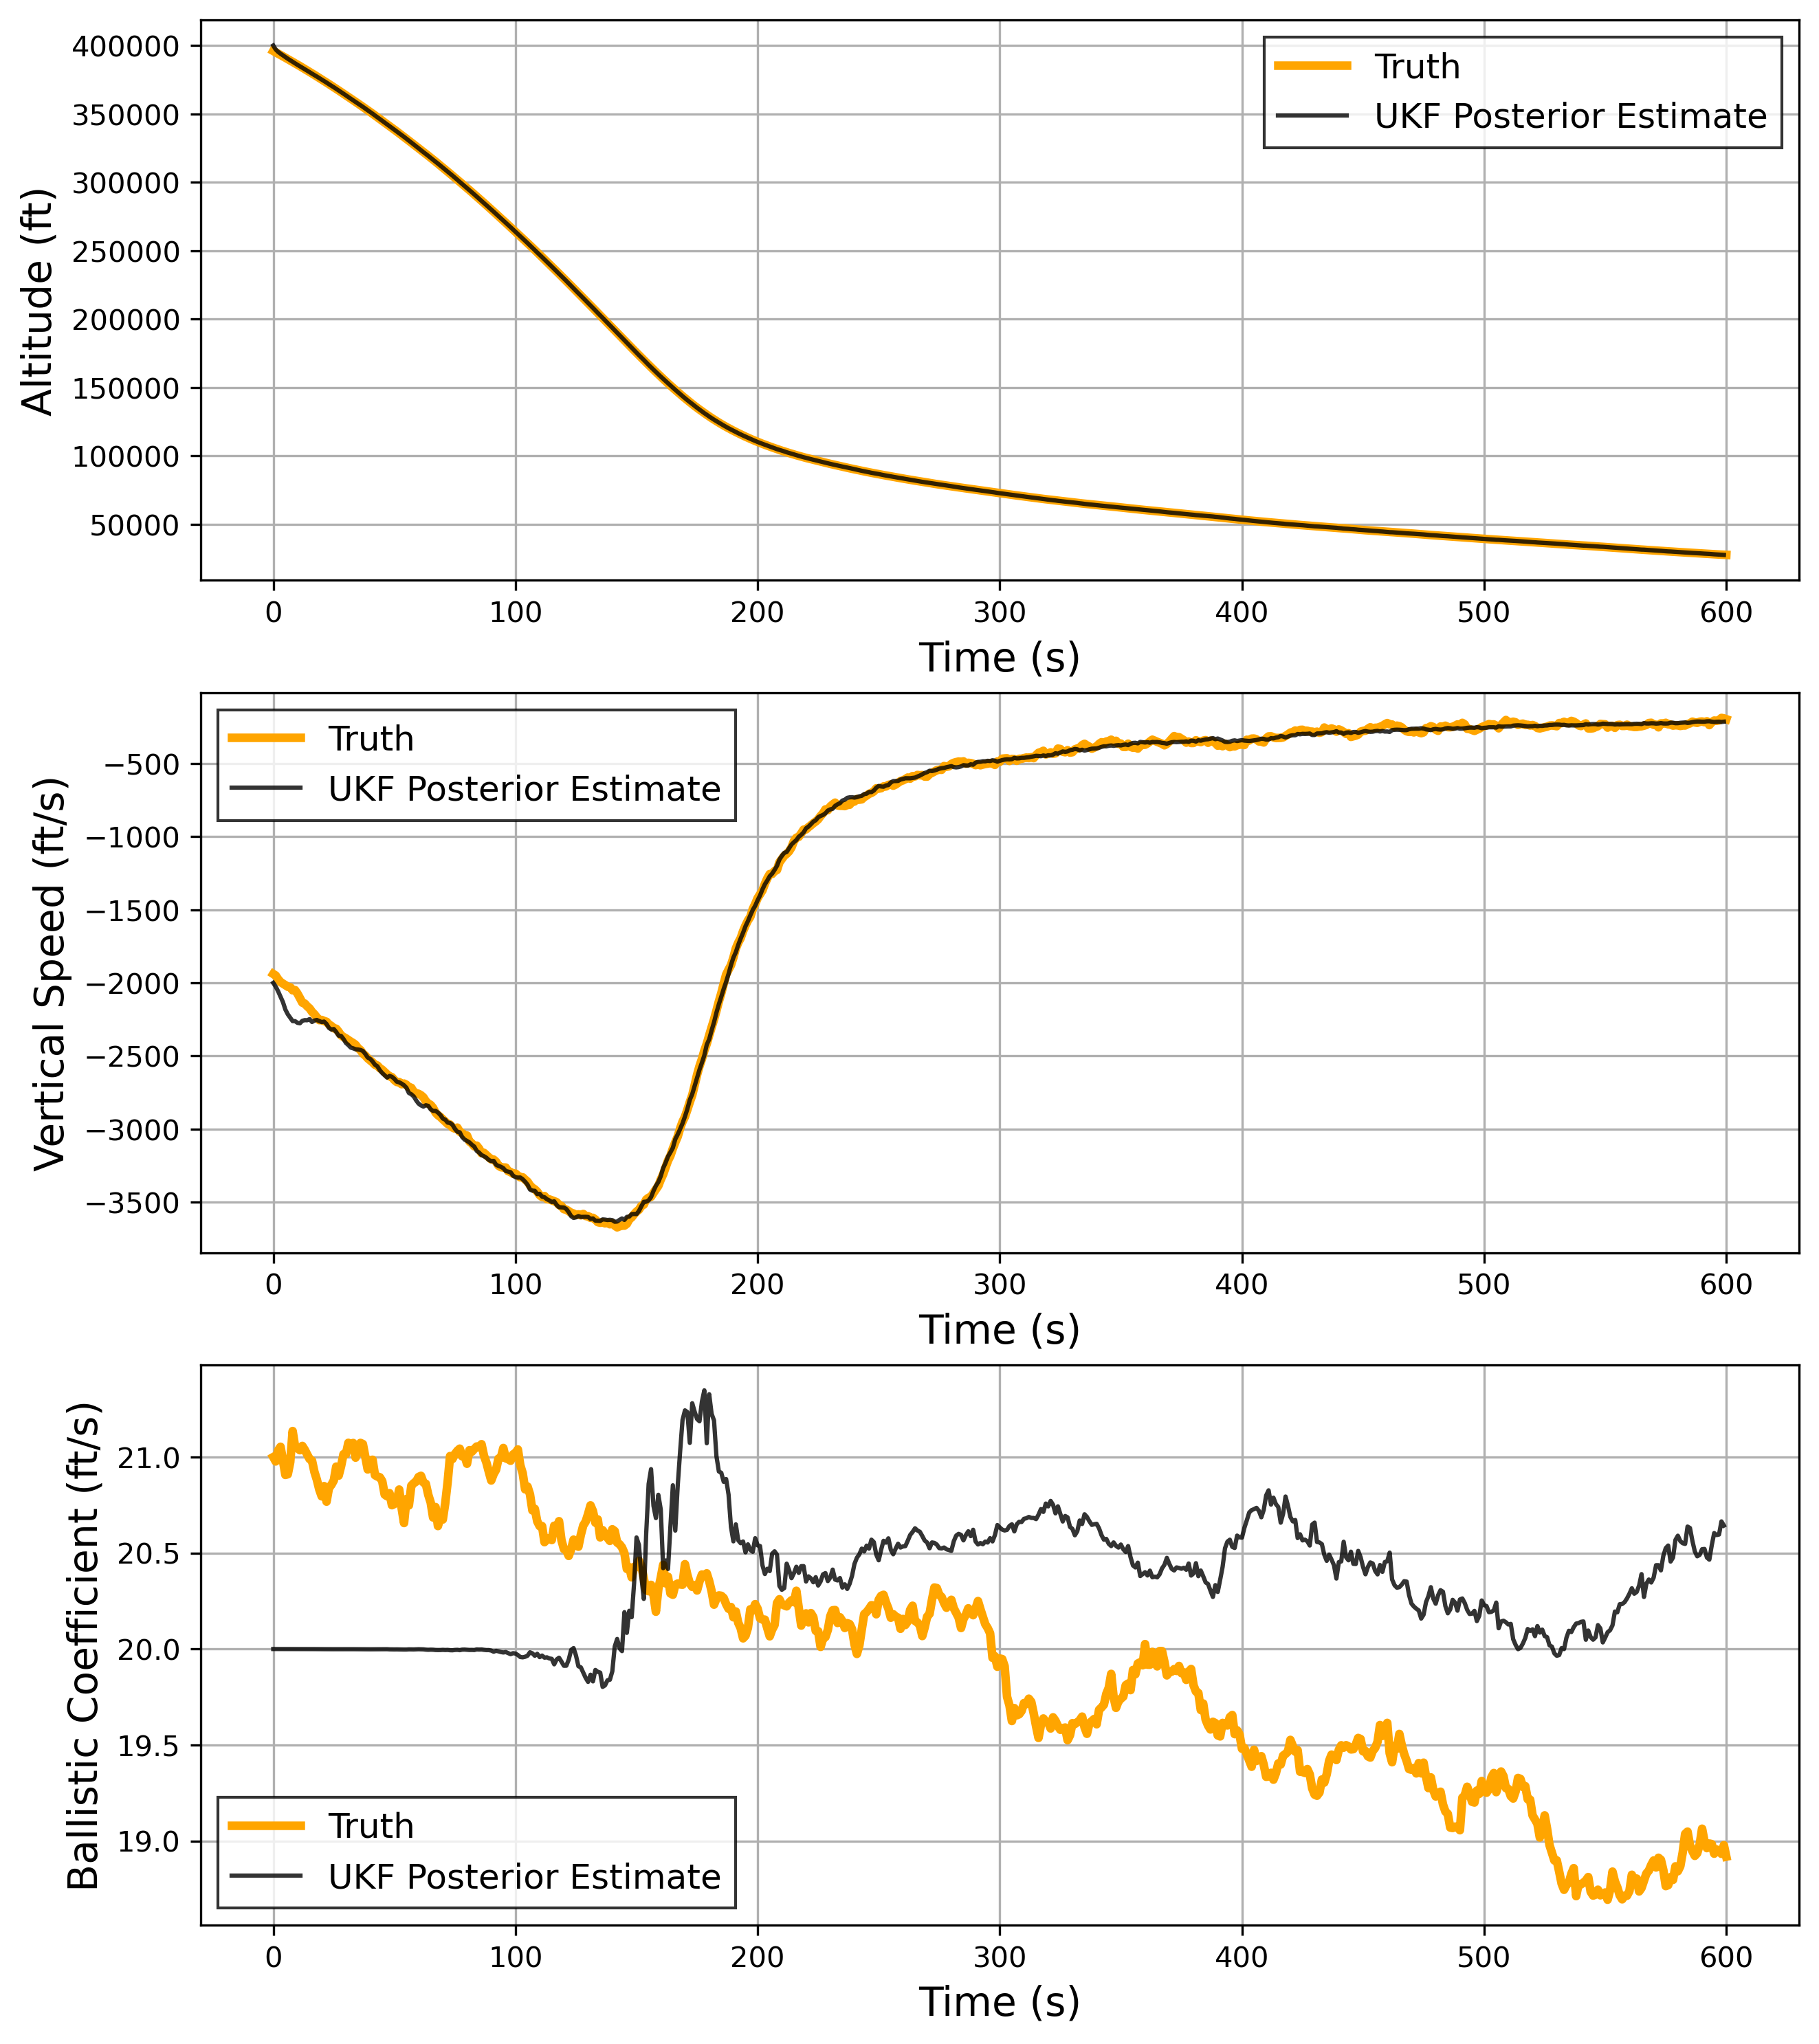

In [658]:
fig, (ax1, ax2, ax3) = plt.subplots(
    dpi=300, figsize=(10, 12), nrows=3, ncols=1, sharex=False
)
ax1.plot(df["hk"], c="orange", linestyle="-", lw=3, label="Truth")
ax1.plot(ukf_res[:, 0], c="black", linestyle="-", alpha=0.8, label="UKF Posterior Estimate")
ax1.grid()
leg = ax1.legend(fancybox=False, fontsize=12)
ax1.set_xlabel("Time (s)", fontsize=14)
ax1.set_ylabel("Altitude (ft)", fontsize=14)

ax2.plot(df["sk"], c="orange", linestyle="-", lw=3, label="Truth")
ax2.plot(ukf_res[:, 1], c="black", linestyle="-", alpha=0.8, label="UKF Posterior Estimate")
ax2.grid()
leg = ax2.legend(fancybox=False, fontsize=12)
ax2.set_xlabel("Time (s)", fontsize=14)
ax2.set_ylabel("Vertical Speed (ft/s)", fontsize=14)

ax3.plot(df["cbk"], c="orange", linestyle="-", lw=3, label="Truth")
ax3.plot(ukf_res[:, 2], c="black", linestyle="-", alpha=0.8, label="UKF Posterior Estimate")
ax3.grid()
leg = ax3.legend(fancybox=False, fontsize=12)
ax3.set_xlabel("Time (s)", fontsize=14)
ax3.set_ylabel("Ballistic Coefficient (ft/s)", fontsize=14)
plt.show()

In [636]:
# These results looked similar to the EKF results, so wanted to make sure they were in fact different
unique, counts = np.unique(ukf_res == res, return_counts=True)
print(dict(zip(unique, counts)))

{False: 1799, True: 4}
